Description:

In 20250327_CentralMetabolism_Kinetic_Genes and 20250414_CarbonUtilization_Kinetic_Genes, we have attempted to fix DEMs and induce flow to new metabolic reactions added to the model that initially had no flow in 20250307_track_reaction_usage script. The purpose of this script is to incorporate the changes in the whole-cell model, whether it is adding a new transport reaction or novel reactions etc, and see how many more new genes are being used compared to the results in 20250307_track_reaction_usage. 

In [47]:
import numpy as np
import ast
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
import networkx as nx
import plotly.express as px

from scipy.special import logsumexp

%matplotlib inline
# sns.set(style='dar|kgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/dev/vivarium-ecoli'))

from ecoli.processes.metabolism_redux_classic import NetworkFlowModel, FlowResult
from ecoli.library.schema import numpy_schema, bulk_name_to_idx, listener_schema, counts
from ecoli.processes.registries import topology_registry
TOPOLOGY = topology_registry.access("ecoli-metabolism-redux")

In [48]:
# load basal new model
time = '400'
date = '2025-01-30'
experiment = 'NEW_updated_bad_rxn'
condition = 'basal'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba_unmodified = output['listeners']['fba_results']
bulk_unmodified = pd.DataFrame(output['bulk'])
f = open(folder + 'agent_steps.pkl', 'rb')
agent_unmodified = dill.load(f)
f.close()

In [49]:
# get commonly stored variables
metabolism_unmodified = agent_unmodified['ecoli-metabolism-redux-classic']
stoichiometry_unmodified = metabolism_unmodified.stoichiometry.copy()
reaction_names_unmodified = metabolism_unmodified.reaction_names
fba_new_reaction_ids_unmodified = metabolism_unmodified.parameters["fba_new_reaction_ids"]
fba_reaction_ids_to_base_reaction_ids_unmodified = metabolism_unmodified.parameters['fba_reaction_ids_to_base_reaction_ids']
metabolites_unmodified = metabolism_unmodified.metabolite_names
binary_kinetic_idx_unmodified = metabolism_unmodified.binary_kinetic_idx
exchange_molecules_unmodified = metabolism_unmodified.exchange_molecules

S_unmodified = stoichiometry_unmodified.copy()
S_unmodified = pd.DataFrame(S_unmodified, index=metabolites_unmodified, columns=reaction_names_unmodified)
homeostatic_count_unmodified = pd.DataFrame(fba_unmodified["homeostatic_metabolite_counts"], columns=metabolism_unmodified.homeostatic_metabolites).loc[24, :]
homeostatic_unmodified = pd.DataFrame(fba_unmodified["target_homeostatic_dmdt"], columns=metabolism_unmodified.homeostatic_metabolites).loc[24, :]
maintenance_unmodified = pd.DataFrame(fba_unmodified["maintenance_target"][1:], columns=['maintenance_reaction']).iat[24, 0]

In [50]:
# load checkpoint 1 model
time = '400'
date = '2025-04-18'
experiment = 'NEW_NewGenes_checkpoint1'
condition = 'basal'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba_cp1 = output['listeners']['fba_results']
bulk_cp1 = pd.DataFrame(output['bulk'])
f = open(folder + 'agent_steps.pkl', 'rb')
agent_cp1 = dill.load(f)
f.close()

In [51]:
# get commonly stored variables
metabolism_cp1 = agent_cp1['ecoli-metabolism-redux-classic']
stoichiometry_cp1 = metabolism_cp1.stoichiometry.copy()
reaction_names_cp1 = metabolism_cp1.reaction_names
fba_new_reaction_ids_cp1 = metabolism_cp1.parameters["fba_new_reaction_ids"]
fba_reaction_ids_to_base_reaction_ids_cp1 = metabolism_cp1.parameters['fba_reaction_ids_to_base_reaction_ids']
metabolites_cp1 = metabolism_cp1.metabolite_names.copy()
binary_kinetic_idx_cp1 = metabolism_cp1.binary_kinetic_idx
exchange_molecules_cp1 = metabolism_cp1.exchange_molecules

S_cp1 = stoichiometry_cp1.copy()
S_cp1 = pd.DataFrame(S_cp1, index=metabolites_cp1, columns=reaction_names_cp1)
homeostatic_count_cp1 = pd.DataFrame(fba_cp1["homeostatic_metabolite_counts"], columns=metabolism_cp1.homeostatic_metabolites).loc[24, :]
homeostatic_cp1 = pd.DataFrame(fba_cp1["target_homeostatic_dmdt"], columns=metabolism_cp1.homeostatic_metabolites).loc[24, :]
maintenance_cp1 = pd.DataFrame(fba_cp1["maintenance_target"][1:], columns=['maintenance_reaction']).iat[24, 0]
kinetic_cp1 = pd.DataFrame(fba_cp1["target_kinetic_fluxes"], columns=metabolism_cp1.kinetic_constraint_reactions).loc[24, :].copy()

In [52]:
print(metabolism_unmodified.allowed_exchange_uptake == metabolism_cp1.allowed_exchange_uptake)
print(metabolism_unmodified.exchange_molecules == metabolism_cp1.exchange_molecules)

True
False


In [53]:
# parameters that are the same across the two simulation
kinetic_reaction_ids = metabolism_cp1.kinetic_constraint_reactions
allowed_exchange_uptake = metabolism_cp1.allowed_exchange_uptake
FREE_RXNS = ["TRANS-RXN-145", "TRANS-RXN0-545", "TRANS-RXN0-474"]
ADDED_RXNS = ['HS-TRANSPORT-RXN-CPD0-1202', 'HS-TRANSPORT-RXN-CPD0-1202 (reverse)',
                   'HS-TRANSPORT-RXN[CCO-OUTER-MEM]-OXAMATE', 'HS-TRANSPORT-RXN[CCO-OUTER-MEM]-OXAMATE (reverse)',
                   'HS-TRANSPORT-RXN[CCO-PM-BAC-NEG]-OXAMATE', 'HS-TRANSPORT-RXN[CCO-PM-BAC-NEG]-OXAMATE (reverse)']

In [54]:
def get_subset_S(S, met_of_interest):
    S_met = S.loc[met_of_interest, :]
    S_met = S_met.loc[:,~np.all(S_met == 0, axis=0)]
    return S_met, S_met.columns

def get_keys(dict, value):
    return [key for key in dict if dict[key] == value]

def test_NetworkFlowModel(objective_weights,
                          uptake_addition = set([]), uptake_removal = set([]), new_exchange_molecules = set([]),
                          add_metabolite = None, add_reaction = None, add_kinetic = None, remove_reaction = None, force_reaction = None):
    # update exchanges
    uptake = metabolism_cp1.allowed_exchange_uptake.copy()
    uptake = set(uptake)
    uptake = uptake | uptake_addition
    uptake = uptake - uptake_removal
    
    exchange_molecules = metabolism_cp1.exchange_molecules.copy()
    exchange_molecules = exchange_molecules | new_exchange_molecules
    
    # update stoichiometry
    reaction_names = metabolism_cp1.reaction_names.copy()
    kinetic_reaction_ids = metabolism_cp1.kinetic_constraint_reactions.copy()
    kinetic = pd.DataFrame(fba_cp1["target_kinetic_fluxes"], columns=metabolism_cp1.kinetic_constraint_reactions).loc[24, :].copy()
    metabolites = metabolism_cp1.metabolite_names.copy()
    
    S_new = stoichiometry_cp1.copy()
    
    if add_metabolite is not None: # add to metabolites list because they are currently not included in the model
        for m in add_metabolite:
            if m not in metabolites:
                metabolites.append(m)
        # append rows of zeros to S_new of length add_metabolite
        S_new = np.concatenate((S_new, np.zeros((len(add_metabolite), S_new.shape[1]))), axis=0)
        print(S_new.shape)
    
    if add_reaction is not None:
        # assert add_reaction is a dictionary
        assert isinstance(add_reaction, dict)
        
        for r,s in add_reaction.items():
            if r not in reaction_names:
                reaction_names.append(r)
            # append columns of reaction stoich to S_new of length add_reaction
            new_reaction = np.zeros((S_new.shape[0], 1))
            for m, v in s.items():
                new_reaction[metabolites.index(m), 0] = v
            S_new = np.concatenate((S_new, new_reaction), axis=1)
        print(S_new.shape)
    
    if add_kinetic is not None:
        # assert add_kinetic is a dictionary
        assert isinstance(add_kinetic, dict)
        
        for r, v in add_kinetic.items():
            if r not in kinetic_reaction_ids:
                kinetic_reaction_ids.append(r)
                kinetic[r] = v
                
    if remove_reaction is not None:
        for r in remove_reaction:
            r_idx = reaction_names.index(r)
            S_new = np.delete(S_new, r_idx, axis=1)
            reaction_names.remove(r)
            if r in kinetic_reaction_ids:
                kinetic_reaction_ids.remove(r)
                del kinetic[r]
                
    if force_reaction is not None:
        force_reaction_idx = np.array([reaction_names.index(r) for r in force_reaction])
    else:
        force_reaction_idx = force_reaction

    print(f'Force Reaction ID is:',force_reaction_idx)
    # Solve NetworkFlowModel
    model = NetworkFlowModel(
            stoich_arr=S_new,
            metabolites=metabolites,
            reactions=reaction_names,
            homeostatic_metabolites=metabolism_cp1.homeostatic_metabolites,
            kinetic_reactions=kinetic_reaction_ids,
            free_reactions=FREE_RXNS)
    model.set_up_exchanges(exchanges=exchange_molecules, uptakes=uptake)
    solution: FlowResult = model.solve(
            homeostatic_concs=homeostatic_count_cp1 * metabolism_cp1.counts_to_molar.asNumber(), # in conc
            homeostatic_dm_targets=np.array(list(dict(homeostatic_cp1).values())), # *10^7
            maintenance_target=maintenance_cp1, # *10^6 ish
            kinetic_targets=np.array(list(dict(kinetic).values())), # *10^6 ish
            # binary_kinetic_idx=binary_kinetic_idx, #7646
            binary_kinetic_idx=None,
            force_flow_idx=force_reaction_idx,
            objective_weights=objective_weights, #same
            upper_flux_bound= 1000000000, # increase to 10^9 because notebook runs FlowResult using Counts, WC runs using conc.   
            solver=cp.GLOP) #SCS. ECOS
    print(f'Optimal objective function reached is: {solution.objective}')
    return solution.velocities, reaction_names, S_new, metabolites, kinetic

## Create dataframes

In [55]:
# all reactions
sim_unmodified = pd.DataFrame(fba_unmodified["estimated_fluxes"], columns= reaction_names_unmodified).loc[24, :].copy()
sim_cp1 = pd.DataFrame(fba_cp1["estimated_fluxes"], columns= reaction_names_cp1).loc[24, :].copy()

# kinetic reactions
kc_target_unmodified = pd.DataFrame(fba_unmodified["target_kinetic_fluxes"], columns= kinetic_reaction_ids).loc[24, :].copy()
kc_target_modified = pd.DataFrame(fba_cp1["target_kinetic_fluxes"], columns= kinetic_reaction_ids).loc[24, :].copy()

In [56]:
df_all = pd.concat([sim_unmodified, sim_cp1], axis=1).fillna(0)
df_all.columns = ['sim_unmodified','sim_cp1_basal']

In [57]:
df_all

,sim_unmodified,sim_cp1_basal
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN,0.0,0.0
1.1.1.127-RXN,0.0,0.0
1.1.1.127-RXN (reverse),0.0,0.0
1.1.1.215-RXN (reverse),0.0,0.0
1.1.1.251-RXN,0.0,0.0
...,...,...
HS-TRANSPORT-RXN[CCO-PM-BAC-NEG]-OXAMATE,0.0,0.0
HS-TRANSPORT-RXN[CCO-PM-BAC-NEG]-OXAMATE (reverse),0.0,0.0
OXAMATE-CARBAMOYLTRANSFERASE-RXN (reverse),0.0,0.0
RXN-11152[CCO-CYTOSOL]-CPD-330/WATER//CPD0-1083/PROTON.45.,0.0,0.0


## Network Flow New Enviornments

In [58]:
conditions = {
    'Isoprimeverose': {
        'Add': set(['CPD0-1202[e]']),
        'Remove': set(['GLC[p]']),
    },
    'Oxamate': {
        'Add': set(['S-ALLANTOIN[e]']),
        'Remove': set(['AMMONIUM[c]', 'OXYGEN-MOLECULE[p]']),
    },
    'Trehalose':{
        'Add': set(['TREHALOSE[e]']),
        'Remove': set(['GLC[p]']),
    },
    'GLC-1-P':{
        'Add': set(['GLC-1-P[e]']),
        'Remove': set(['GLC[p]']),
    },
    '3-HYDROXYPHENYL-PROPIONATE':{
        'Add': set(['3-HYDROXYPHENYL-PROPIONATE[e]']),
        'Remove': set(['GLC[p]'])
    },
    '3-PHENYLPROPIONATE':{
        'Add': set(['3-PHENYLPROPIONATE[e]']),
        'Remove': set(['GLC[p]'])
    },
    'cinnate':{
        'Add': set(['CPD-10797[e]', 'CPD-674[e]']),
        'Remove': set(['GLC[p]'])
    },
    'L-galactonate':{
        'Add': set(['CPD0-1083[e]']),
        'Remove': set(['GLC[p]'])
    },
    'D-GLUCARATE':{
        'Add': set(['D-GLUCARATE[e]']),
        'Remove': set(['GLC[p]'])
    }
}

In [59]:
for condition_name, condition in conditions.items():
    uptake = metabolism_cp1.allowed_exchange_uptake.copy()
    uptake = set(uptake)
    uptake = uptake | condition['Add']
    uptake = uptake - condition['Remove']

    model = NetworkFlowModel(
            stoich_arr=stoichiometry_cp1,
            metabolites=metabolites_cp1,
            reactions=reaction_names_cp1,
            homeostatic_metabolites=metabolism_cp1.homeostatic_metabolites,
            kinetic_reactions=kinetic_reaction_ids,
            free_reactions=FREE_RXNS)
    model.set_up_exchanges(exchanges=exchange_molecules_cp1, uptakes=uptake)
    solution: FlowResult = model.solve(
            homeostatic_concs=homeostatic_count_cp1 * metabolism_cp1.counts_to_molar.asNumber(), # in conc
            homeostatic_dm_targets=np.array(list(dict(homeostatic_cp1).values())), # *10^7
            maintenance_target=maintenance_cp1, # *10^6 ish
            kinetic_targets=np.array(list(dict(kinetic_cp1).values())), # *10^6 ish
            # binary_kinetic_idx=binary_kinetic_idx, #7646
            binary_kinetic_idx=None,
            force_flow_idx=None,
            objective_weights= {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.000001}, #same
            upper_flux_bound= 1000000000, # increase to 10^9 because notebook runs FlowResult using Counts, WC runs using conc.   
            solver=cp.GLOP)
    
    # get the fluxes
    sim_flux = pd.DataFrame({f'sim_cp1_{condition_name}': solution.velocities}, index = reaction_names_cp1)
    df_all = pd.concat([df_all, sim_flux], axis=1)
    
    print(f"""Finished enviornment: {condition_name}""")

Finished enviornment: Isoprimeverose
Finished enviornment: Oxamate
Finished enviornment: Trehalose
Finished enviornment: GLC-1-P
Finished enviornment: 3-HYDROXYPHENYL-PROPIONATE
Finished enviornment: 3-PHENYLPROPIONATE
Finished enviornment: cinnate
Finished enviornment: L-galactonate
Finished enviornment: D-GLUCARATE


In [60]:
df_all

,sim_unmodified,sim_cp1_basal,sim_cp1_Isoprimeverose,sim_cp1_Oxamate,sim_cp1_Trehalose,sim_cp1_GLC-1-P,sim_cp1_3-HYDROXYPHENYL-PROPIONATE,sim_cp1_3-PHENYLPROPIONATE,sim_cp1_cinnate,sim_cp1_L-galactonate,sim_cp1_D-GLUCARATE
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1.1.1.127-RXN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1.1.1.127-RXN (reverse),0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1.1.1.215-RXN (reverse),0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1.1.1.251-RXN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...
HS-TRANSPORT-RXN[CCO-PM-BAC-NEG]-OXAMATE,0.0,0.0,-0.0,34422.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
HS-TRANSPORT-RXN[CCO-PM-BAC-NEG]-OXAMATE (reverse),0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
OXAMATE-CARBAMOYLTRANSFERASE-RXN (reverse),0.0,0.0,-0.0,34422.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
RXN-11152[CCO-CYTOSOL]-CPD-330/WATER//CPD0-1083/PROTON.45.,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [61]:
df_all['is_new'] = 'Old Reactions'
df_all.loc[ADDED_RXNS, 'is_new'] = 'Heena\'s Reactions'
df_all.loc[fba_new_reaction_ids_unmodified, 'is_new'] = 'New Reactions'

df_all['kinetic'] = [kinetic_cp1[r] if r in kinetic_reaction_ids else False for r in df_all.index]

## Calculate % gene usage at checkpoint 1

In [62]:
df_all.head()

,sim_unmodified,sim_cp1_basal,sim_cp1_Isoprimeverose,sim_cp1_Oxamate,sim_cp1_Trehalose,sim_cp1_GLC-1-P,sim_cp1_3-HYDROXYPHENYL-PROPIONATE,sim_cp1_3-PHENYLPROPIONATE,sim_cp1_cinnate,sim_cp1_L-galactonate,sim_cp1_D-GLUCARATE,is_new,kinetic
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
1.1.1.127-RXN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
1.1.1.127-RXN (reverse),0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
1.1.1.215-RXN (reverse),0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
1.1.1.251-RXN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False


In [63]:
%store -r df_gene_usage genes_to_enzymes df_all_gene_usage new_genes
df_gene_usage

,Enzyme encoded,Reactions,has_kinetic,basal,acetate,rich,anaerobic_basal,anaerobic_acetate,anaerobic_rich,is_used
Gene ID (EcoCyc),,,,,,,,,,
EG10022,ISOCIT-LYASE,[ISOCIT-CLEAV-RXN],False,1,1,0,0,1,0,True
EG10023,MALATE-SYNTHASE,[MALSYN-RXN],False,1,1,0,0,0,0,True
EG11942,CPLX0-7955,"[RXN0-1981, RXN0-5111, TRANS-RXN0-576]",False,0,0,0,0,0,0,False
EG11724,EG11724-MONOMER,[TRANS-RXN0-447],False,0,0,0,0,0,0,False
EG12462,CPLX0-7535,[RXN0-2162],False,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...
G7248,CPLX0-8290,[RXN0-5052],False,0,0,0,0,0,0,False
G7408,G7408-MONOMER,[RXN0-5186],True,0,0,0,0,0,0,False
EG12517,ABC-46-CPLX,"[TRANS-RXN0-492, TRANS-RXN0-491]",False,0,0,0,0,0,0,False


In [64]:
df_all

,sim_unmodified,sim_cp1_basal,sim_cp1_Isoprimeverose,sim_cp1_Oxamate,sim_cp1_Trehalose,sim_cp1_GLC-1-P,sim_cp1_3-HYDROXYPHENYL-PROPIONATE,sim_cp1_3-PHENYLPROPIONATE,sim_cp1_cinnate,sim_cp1_L-galactonate,sim_cp1_D-GLUCARATE,is_new,kinetic
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
1.1.1.127-RXN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
1.1.1.127-RXN (reverse),0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
1.1.1.215-RXN (reverse),0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
1.1.1.251-RXN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
HS-TRANSPORT-RXN[CCO-PM-BAC-NEG]-OXAMATE,0.0,0.0,-0.0,34422.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Heena's Reactions,False
HS-TRANSPORT-RXN[CCO-PM-BAC-NEG]-OXAMATE (reverse),0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Heena's Reactions,False
OXAMATE-CARBAMOYLTRANSFERASE-RXN (reverse),0.0,0.0,-0.0,34422.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
RXN-11152[CCO-CYTOSOL]-CPD-330/WATER//CPD0-1083/PROTON.45.,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False


In [65]:
df_all_gene_usage

,Enzyme encoded,Reactions,has_kinetic,basal,acetate,rich,anaerobic_basal,anaerobic_acetate,anaerobic_rich,is_used
Gene ID (EcoCyc),,,,,,,,,,
EG11679,AAS-MONOMER,"[ACYLGPEACYLTRANS-RXN, RXN-5741, RXN0-5513]",False,0,0,0,0,0,0,False
EG11647,ACETYL-COA-CARBOXYLTRANSFER-CPLX,[RXN0-5055],False,1,1,1,1,0,0,True
EG10276,BIOTIN-CARBOXYL-CPLX,[BIOTIN-CARBOXYL-RXN],True,1,1,1,1,0,0,True
EG10217,ACETYL-COA-CARBOXYLTRANSFER-CPLX,[RXN0-5055],False,1,1,1,1,0,0,True
EG10022,ISOCIT-LYASE,[ISOCIT-CLEAV-RXN],False,1,1,0,0,1,0,True
...,...,...,...,...,...,...,...,...,...,...
EG12215,YHHO-MONOMER,"[RXN0-5205, 3.6.3.3-RXN, TRANS-RXN-452]",False,0,0,0,0,0,0,False
G7017,ABC-63-CPLX,[ABC-63-RXN],False,0,0,0,0,0,0,False
G7018,ABC-63-CPLX,[ABC-63-RXN],False,0,0,0,0,0,0,False


In [66]:
df_all_gene_usage_cp1

,Enzyme encoded,Reactions,has_kinetic,basal,acetate,rich,anaerobic_basal,anaerobic_acetate,anaerobic_rich,sim_cp1_basal,sim_cp1_Isoprimeverose,sim_cp1_Oxamate,sim_cp1_Trehalose,sim_cp1_GLC-1-P,sim_cp1_3-HYDROXYPHENYL-PROPIONATE,sim_cp1_3-PHENYLPROPIONATE,sim_cp1_cinnate,sim_cp1_L-galactonate,sim_cp1_D-GLUCARATE,is_used
Gene ID (EcoCyc),,,,,,,,,,,,,,,,,,,,
EG11679,AAS-MONOMER,"[ACYLGPEACYLTRANS-RXN, RXN-5741, RXN0-5513]",False,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,True
EG11647,ACETYL-COA-CARBOXYLTRANSFER-CPLX,[RXN0-5055],False,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,True
EG10276,BIOTIN-CARBOXYL-CPLX,[BIOTIN-CARBOXYL-RXN],True,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,True
EG10217,ACETYL-COA-CARBOXYLTRANSFER-CPLX,[RXN0-5055],False,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,True
EG10022,ISOCIT-LYASE,[ISOCIT-CLEAV-RXN],False,1,1,0,0,1,0,0,0,1,0,0,1,1,1,0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EG12215,YHHO-MONOMER,"[RXN0-5205, 3.6.3.3-RXN, TRANS-RXN-452]",False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
G7017,ABC-63-CPLX,[ABC-63-RXN],False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
G7018,ABC-63-CPLX,[ABC-63-RXN],False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False


In [67]:
df_all

,sim_unmodified,sim_cp1_basal,sim_cp1_Isoprimeverose,sim_cp1_Oxamate,sim_cp1_Trehalose,sim_cp1_GLC-1-P,sim_cp1_3-HYDROXYPHENYL-PROPIONATE,sim_cp1_3-PHENYLPROPIONATE,sim_cp1_cinnate,sim_cp1_L-galactonate,sim_cp1_D-GLUCARATE,is_new,kinetic
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
1.1.1.127-RXN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
1.1.1.127-RXN (reverse),0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
1.1.1.215-RXN (reverse),0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
1.1.1.251-RXN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
HS-TRANSPORT-RXN[CCO-PM-BAC-NEG]-OXAMATE,0.0,0.0,-0.0,34422.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Heena's Reactions,False
HS-TRANSPORT-RXN[CCO-PM-BAC-NEG]-OXAMATE (reverse),0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Heena's Reactions,False
OXAMATE-CARBAMOYLTRANSFERASE-RXN (reverse),0.0,0.0,-0.0,34422.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
RXN-11152[CCO-CYTOSOL]-CPD-330/WATER//CPD0-1083/PROTON.45.,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False


In [68]:
conditions_names = ['sim_cp1_basal','sim_cp1_Isoprimeverose','sim_cp1_Oxamate','sim_cp1_Trehalose','sim_cp1_GLC-1-P',
                    'sim_cp1_3-HYDROXYPHENYL-PROPIONATE','sim_cp1_3-PHENYLPROPIONATE','sim_cp1_cinnate','sim_cp1_L-galactonate',
                    'sim_cp1_D-GLUCARATE']
conditions_previous = ['basal', 'acetate', 'rich', 'anaerobic_basal', 'anaerobic_acetate', 'anaerobic_rich']
conditions_all = conditions_previous + conditions_names

df_all_gene_usage = df_all_gene_usage.copy()
gene_used_before = df_gene_usage['is_used']
df_all_gene_usage = df_all_gene_usage.drop(['is_used'], axis = 1)
df_all_gene_usage_cp1 = df_all_gene_usage.copy()
reaction_catalysts = metabolism_cp1.parameters["reaction_catalysts"]

for condition in conditions_names:
    df_all_gene_usage_cp1[condition] = 0
    for rxn in reaction_names_cp1:
        is_used = df_all.loc[rxn, condition]
        enzymes = reaction_catalysts.get(rxn,[])
        for enz in enzymes:
            enz = enz[:-3]
            genes = get_keys(genes_to_enzymes, enz)
            for gene in genes:
                if is_used:
                    df_all_gene_usage_cp1.loc[gene, condition] += 1
                if rxn in kinetic_reaction_ids:
                    df_all_gene_usage_cp1.loc[gene, 'has_kinetic'] = True


# tally usage
df_all_gene_usage_cp1['is_used'] = np.any(df_all_gene_usage_cp1[conditions_all] > 0, axis=1)
df_gene_usage_cp1 = df_all_gene_usage_cp1.loc[new_genes,:]

In [69]:
df_gene_usage_cp1

,Enzyme encoded,Reactions,has_kinetic,basal,acetate,rich,anaerobic_basal,anaerobic_acetate,anaerobic_rich,sim_cp1_basal,sim_cp1_Isoprimeverose,sim_cp1_Oxamate,sim_cp1_Trehalose,sim_cp1_GLC-1-P,sim_cp1_3-HYDROXYPHENYL-PROPIONATE,sim_cp1_3-PHENYLPROPIONATE,sim_cp1_cinnate,sim_cp1_L-galactonate,sim_cp1_D-GLUCARATE,is_used
Gene ID (EcoCyc),,,,,,,,,,,,,,,,,,,,
EG10022,ISOCIT-LYASE,[ISOCIT-CLEAV-RXN],False,1,1,0,0,1,0,0,0,1,0,0,1,1,1,0,1,True
EG10023,MALATE-SYNTHASE,[MALSYN-RXN],False,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True
EG11942,CPLX0-7955,"[RXN0-1981, RXN0-5111, TRANS-RXN0-576]",False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
EG11724,EG11724-MONOMER,[TRANS-RXN0-447],False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
EG12462,CPLX0-7535,[RXN0-2162],False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G7248,CPLX0-8290,[RXN0-5052],False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
G7408,G7408-MONOMER,[RXN0-5186],True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
EG12517,ABC-46-CPLX,"[TRANS-RXN0-492, TRANS-RXN0-491]",False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False


In [70]:
# previous % gene usage
num_genes = len(gene_used_before)
assert len(gene_used_before) == len(df_gene_usage_cp1['is_used']), 'Different number of new genes'

perc_gene_usage_prev = sum(gene_used_before)/num_genes
perc_gene_usage_new  = sum(df_gene_usage_cp1['is_used'])/num_genes

print(f'% new genes usage before checkpoint 1 is: {perc_gene_usage_prev: 0.2%}')
print(f'    % new genes usage at checkpoint 1 is: {perc_gene_usage_new: 0.2%}')

% new genes usage before checkpoint 1 is:  4.56%
    % new genes usage at checkpoint 1 is:  12.38%


In [71]:
df_gene_usage_cp1[df_gene_usage_cp1['is_used']]

,Enzyme encoded,Reactions,has_kinetic,basal,acetate,rich,anaerobic_basal,anaerobic_acetate,anaerobic_rich,sim_cp1_basal,sim_cp1_Isoprimeverose,sim_cp1_Oxamate,sim_cp1_Trehalose,sim_cp1_GLC-1-P,sim_cp1_3-HYDROXYPHENYL-PROPIONATE,sim_cp1_3-PHENYLPROPIONATE,sim_cp1_cinnate,sim_cp1_L-galactonate,sim_cp1_D-GLUCARATE,is_used
Gene ID (EcoCyc),,,,,,,,,,,,,,,,,,,,
EG10022,ISOCIT-LYASE,[ISOCIT-CLEAV-RXN],False,1,1,0,0,1,0,0,0,1,0,0,1,1,1,0,1,True
EG10023,MALATE-SYNTHASE,[MALSYN-RXN],False,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True
EG10033,GLUCOSE-1-PHOSPHAT-CPLX,"[GLUCOSE-1-PHOSPHAT-RXN, RXN0-1001]",True,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,True
G6275,G6275-MONOMER,[UREIDOGLYCOLATE-LYASE-RXN],False,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,True
G6850,YNFJ-MONOMER,[RXN0-2501],False,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,True
G7285,G7285-MONOMER,[ACETALD-DEHYDROG-RXN],False,1,1,2,1,1,0,1,1,1,1,1,1,1,1,1,1,True
G7309,FOCB-MONOMER,[TRANS-RXN-1],False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True
G6428,CPLX0-201,[RXN0-313],True,0,0,1,0,0,0,0,0,0,0,0,1,1,1,1,1,True
EG11905,CPLX0-8584,[RXN0-313],False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,True


## Scatterplot

### 1. kinetic scatterplot

In [72]:
# import old basal data
# load basal new model
time = '400'
date = '2025-02-13'
experiment = 'OLD_updated_bad_rxn'
condition = 'basal'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba_old = output['listeners']['fba_results']
bulk_old = pd.DataFrame(output['bulk'])
f = open(folder + 'agent_steps.pkl', 'rb')
agent_old = dill.load(f)
f.close()

In [73]:
# get commonly stored variables
metabolism_old = agent_old['ecoli-metabolism-redux-classic']
stoichiometry_old = metabolism_old.stoichiometry.copy()
reaction_names_old = metabolism_old.reaction_names
fba_new_reaction_ids_old = metabolism_old.parameters["fba_new_reaction_ids"]
fba_reaction_ids_to_base_reaction_ids_old = metabolism_old.parameters['fba_reaction_ids_to_base_reaction_ids']
metabolites_old = metabolism_old.metabolite_names
binary_kinetic_idx_old = metabolism_old.binary_kinetic_idx

In [74]:
# create dataframe
old_sim = pd.DataFrame(fba_old["estimated_fluxes"], columns= reaction_names_old).loc[24, :].copy()
old_kc_target = pd.DataFrame(fba_old["target_kinetic_fluxes"], columns= kinetic_reaction_ids).loc[24, :].copy()
temp = df_all.copy()
temp.insert(0, 'sim_old', old_sim)

df_all = temp.fillna(0)
df_kc  = pd.DataFrame({'old_kc_target': old_kc_target, 'new_kc_target_unmodified': kc_target_unmodified, 'new_kc_target_cp1': kc_target_modified,
                       'old_kc_sim': old_sim[kinetic_reaction_ids], 'new_kc_sim_unmodified': sim_unmodified[kinetic_reaction_ids], 'new_kc_sim_cp1': sim_cp1[kinetic_reaction_ids],
                       'is_new': ['New Reactions' if id in fba_new_reaction_ids_cp1 else 'Old Reactions' for id in kinetic_reaction_ids]})
cols = conditions_names + ['is_new', 'kinetic']
df_kc_cp1 = df_all.loc[kinetic_reaction_ids, cols]

In [75]:
df_kc.head()

,old_kc_target,new_kc_target_unmodified,new_kc_target_cp1,old_kc_sim,new_kc_sim_unmodified,new_kc_sim_cp1,is_new
1.1.1.39-RXN,17428.0,17428.0,15764.0,0.0,0.0,0.0,Old Reactions
1.1.1.83-RXN,930.0,930.0,698.0,0.0,0.0,0.0,Old Reactions
1.13.11.16-RXN,100.0,100.0,67.0,0.0,0.0,0.0,New Reactions
2.1.1.79-RXN-CPD-18361/S-ADENOSYLMETHIONINE//CPD-18373/ADENOSYL-HOMO-CYS/PROTON.67.,87.0,87.0,90.0,0.0,0.0,0.0,New Reactions
2.1.1.79-RXN-CPD-18362/S-ADENOSYLMETHIONINE//CPD-18406/ADENOSYL-HOMO-CYS/PROTON.67.,87.0,87.0,90.0,0.0,0.0,0.0,New Reactions


In [76]:
df_kc_cp1.head()

,sim_cp1_basal,sim_cp1_Isoprimeverose,sim_cp1_Oxamate,sim_cp1_Trehalose,sim_cp1_GLC-1-P,sim_cp1_3-HYDROXYPHENYL-PROPIONATE,sim_cp1_3-PHENYLPROPIONATE,sim_cp1_cinnate,sim_cp1_L-galactonate,sim_cp1_D-GLUCARATE,is_new,kinetic
1.1.1.39-RXN,0.0,-0.0,-0.0,-0.0,-0.0,-0.0000,-0.000000,-0.0,-0.0,-0.0,Old Reactions,15764.0
1.1.1.83-RXN,0.0,-0.0,-0.0,-0.0,-0.0,-0.0000,-0.000000,-0.0,-0.0,-0.0,Old Reactions,698.0
1.13.11.16-RXN,0.0,0.0,-0.0,0.0,0.0,295747.0625,276318.423358,0.0,0.0,0.0,New Reactions,67.0
2.1.1.79-RXN-CPD-18361/S-ADENOSYLMETHIONINE//CPD-18373/ADENOSYL-HOMO-CYS/PROTON.67.,0.0,-0.0,-0.0,-0.0,-0.0,-0.0000,-0.000000,-0.0,-0.0,-0.0,New Reactions,90.0
2.1.1.79-RXN-CPD-18362/S-ADENOSYLMETHIONINE//CPD-18406/ADENOSYL-HOMO-CYS/PROTON.67.,0.0,-0.0,-0.0,-0.0,-0.0,-0.0000,-0.000000,-0.0,-0.0,-0.0,New Reactions,90.0


In [77]:
df_kc_cp1_log = df_kc_cp1.copy()
df_kc_cp1_log['kinetic'] = df_kc_cp1_log['kinetic'].apply(pd.to_numeric, errors='coerce')
cols = conditions_names + ['kinetic']
df_kc_cp1_log.loc[:,cols] += 1e-6
df_kc_cp1_log.loc[:,cols] = np.log10(df_kc_cp1_log.loc[:,cols])
df_kc_cp1_log
# df_kc_cp1_log.to_csv('notebooks/Heena notebooks/Metabolism_New Genes/df_kc_cp1.csv')

,sim_cp1_basal,sim_cp1_Isoprimeverose,sim_cp1_Oxamate,sim_cp1_Trehalose,sim_cp1_GLC-1-P,sim_cp1_3-HYDROXYPHENYL-PROPIONATE,sim_cp1_3-PHENYLPROPIONATE,sim_cp1_cinnate,sim_cp1_L-galactonate,sim_cp1_D-GLUCARATE,is_new,kinetic
1.1.1.39-RXN,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,Old Reactions,4.197666
1.1.1.83-RXN,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,Old Reactions,2.843855
1.13.11.16-RXN,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,5.470920,5.441410,-6.000000,-6.000000,-6.000000,New Reactions,1.826075
2.1.1.79-RXN-CPD-18361/S-ADENOSYLMETHIONINE//CPD-18373/ADENOSYL-HOMO-CYS/PROTON.67.,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,New Reactions,1.954243
2.1.1.79-RXN-CPD-18362/S-ADENOSYLMETHIONINE//CPD-18406/ADENOSYL-HOMO-CYS/PROTON.67.,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,New Reactions,1.954243
...,...,...,...,...,...,...,...,...,...,...,...,...
UGD-RXN,1.875061,1.875061,1.875061,1.875061,1.875061,1.875061,1.875061,1.875061,1.875061,1.875061,Old Reactions,1.812913
UNDECAPRENYL-DIPHOSPHATASE-RXN[CCO-CYTOSOL]-UNDECAPRENYL-DIPHOSPHATE/WATER//CPD-9646/Pi/PROTON.64.__PGPPHOSPHAB-MONOMER,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,Old Reactions,1.000000
URA-PHOSPH-RXN,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,Old Reactions,3.122871
UROGENIIISYN-RXN,1.431364,1.431364,1.431364,1.431364,1.431364,1.431364,1.431364,1.431364,1.431364,1.431364,Old Reactions,4.350248


In [78]:
# work with df_kc_cp1 or df_kc_cp1_log
# create a dataframe with rows as reactions, col1 as flux closest to target, col2 being condition(s) that have that flux
df_kc_cp1_combined = pd.DataFrame({'flux': np.NaN, 'condition': 'none', 'target': df_kc_cp1['kinetic']}, index=kinetic_reaction_ids)

# create temporary dataframe that tracks the difference between sim flux and target
temp = df_kc_cp1.copy()
temp.replace(0, np.nan, inplace=True)
for condition in conditions_names:
    temp.loc[:, condition] = np.abs(temp.loc[:, condition] - df_kc_cp1['kinetic'].values)

# parse by reaction (index) to find the conditions with flux closest to target (minimal difference)
for reaction in temp.index:
    # get the condition with the minimum difference
    min_diff = temp.loc[reaction, conditions_names].min()
    # get the condition(s) with the minimum difference
    conditions = temp.loc[reaction, conditions_names][temp.loc[reaction, conditions_names] == min_diff].index.tolist()
    # update the dataframe
    if np.all(df_kc_cp1.loc[reaction,conditions_names] == 0):
        df_kc_cp1_combined.loc[reaction, 'flux'] = 0
    else:
        df_kc_cp1_combined.loc[reaction, 'flux'] = df_kc_cp1.loc[reaction,conditions[0]]
        if conditions == conditions_names:
            df_kc_cp1_combined.loc[reaction, 'condition'] = 'all'
        else:
            df_kc_cp1_combined.loc[reaction, 'condition'] = ', '.join(conditions)

df_kc_cp1_log_combined = df_kc_cp1_combined.copy()         
df_kc_cp1_log_combined['target'] = df_kc_cp1_log_combined['target'].apply(pd.to_numeric, errors='coerce')
df_kc_cp1_log_combined.loc[:,['flux','target']] += 1e-6
df_kc_cp1_log_combined.loc[:,['flux','target']] = np.log10(df_kc_cp1_log_combined.loc[:,['flux','target']])

df_kc_cp1_log_combined.to_csv('notebooks/Heena notebooks/Metabolism_New Genes/df_kc_cp1_combined.csv', index=True, index_label = 'ReactionID')

In [79]:
df_kc_cp1_combined

,flux,condition,target
1.1.1.39-RXN,0.000000,none,15764.0
1.1.1.83-RXN,0.000000,none,698.0
1.13.11.16-RXN,276318.423358,sim_cp1_3-PHENYLPROPIONATE,67.0
2.1.1.79-RXN-CPD-18361/S-ADENOSYLMETHIONINE//CPD-18373/ADENOSYL-HOMO-CYS/PROTON.67.,0.000000,none,90.0
2.1.1.79-RXN-CPD-18362/S-ADENOSYLMETHIONINE//CPD-18406/ADENOSYL-HOMO-CYS/PROTON.67.,0.000000,none,90.0
...,...,...,...
UGD-RXN,75.000000,sim_cp1_basal,65.0
UNDECAPRENYL-DIPHOSPHATASE-RXN[CCO-CYTOSOL]-UNDECAPRENYL-DIPHOSPHATE/WATER//CPD-9646/Pi/PROTON.64.__PGPPHOSPHAB-MONOMER,0.000000,none,10.0
URA-PHOSPH-RXN,0.000000,none,1327.0
UROGENIIISYN-RXN,27.000000,all,22400.0


### 1. All reaction scatterplot

In [80]:
df_all

,sim_old,sim_unmodified,sim_cp1_basal,sim_cp1_Isoprimeverose,sim_cp1_Oxamate,sim_cp1_Trehalose,sim_cp1_GLC-1-P,sim_cp1_3-HYDROXYPHENYL-PROPIONATE,sim_cp1_3-PHENYLPROPIONATE,sim_cp1_cinnate,sim_cp1_L-galactonate,sim_cp1_D-GLUCARATE,is_new,kinetic
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
1.1.1.127-RXN,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
1.1.1.127-RXN (reverse),0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
1.1.1.215-RXN (reverse),0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
1.1.1.251-RXN,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HS-TRANSPORT-RXN[CCO-PM-BAC-NEG]-OXAMATE,0.0,0.0,0.0,-0.0,34422.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Heena's Reactions,False
HS-TRANSPORT-RXN[CCO-PM-BAC-NEG]-OXAMATE (reverse),0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Heena's Reactions,False
OXAMATE-CARBAMOYLTRANSFERASE-RXN (reverse),0.0,0.0,0.0,-0.0,34422.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False
RXN-11152[CCO-CYTOSOL]-CPD-330/WATER//CPD0-1083/PROTON.45.,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,Old Reactions,False


In [81]:
df_kc_cp1_log_combined

,flux,condition,target
1.1.1.39-RXN,-6.000000,none,4.197666
1.1.1.83-RXN,-6.000000,none,2.843855
1.13.11.16-RXN,5.441410,sim_cp1_3-PHENYLPROPIONATE,1.826075
2.1.1.79-RXN-CPD-18361/S-ADENOSYLMETHIONINE//CPD-18373/ADENOSYL-HOMO-CYS/PROTON.67.,-6.000000,none,1.954243
2.1.1.79-RXN-CPD-18362/S-ADENOSYLMETHIONINE//CPD-18406/ADENOSYL-HOMO-CYS/PROTON.67.,-6.000000,none,1.954243
...,...,...,...
UGD-RXN,1.875061,sim_cp1_basal,1.812913
UNDECAPRENYL-DIPHOSPHATASE-RXN[CCO-CYTOSOL]-UNDECAPRENYL-DIPHOSPHATE/WATER//CPD-9646/Pi/PROTON.64.__PGPPHOSPHAB-MONOMER,-6.000000,none,1.000000
URA-PHOSPH-RXN,-6.000000,none,3.122871
UROGENIIISYN-RXN,1.431364,all,4.350248


In [82]:
df_kc_cp1

,sim_cp1_basal,sim_cp1_Isoprimeverose,sim_cp1_Oxamate,sim_cp1_Trehalose,sim_cp1_GLC-1-P,sim_cp1_3-HYDROXYPHENYL-PROPIONATE,sim_cp1_3-PHENYLPROPIONATE,sim_cp1_cinnate,sim_cp1_L-galactonate,sim_cp1_D-GLUCARATE,is_new,kinetic
1.1.1.39-RXN,0.0,-0.0,-0.0,-0.0,-0.0,-0.0000,-0.000000,-0.0,-0.0,-0.0,Old Reactions,15764.0
1.1.1.83-RXN,0.0,-0.0,-0.0,-0.0,-0.0,-0.0000,-0.000000,-0.0,-0.0,-0.0,Old Reactions,698.0
1.13.11.16-RXN,0.0,0.0,-0.0,0.0,0.0,295747.0625,276318.423358,0.0,0.0,0.0,New Reactions,67.0
2.1.1.79-RXN-CPD-18361/S-ADENOSYLMETHIONINE//CPD-18373/ADENOSYL-HOMO-CYS/PROTON.67.,0.0,-0.0,-0.0,-0.0,-0.0,-0.0000,-0.000000,-0.0,-0.0,-0.0,New Reactions,90.0
2.1.1.79-RXN-CPD-18362/S-ADENOSYLMETHIONINE//CPD-18406/ADENOSYL-HOMO-CYS/PROTON.67.,0.0,-0.0,-0.0,-0.0,-0.0,-0.0000,-0.000000,-0.0,-0.0,-0.0,New Reactions,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...
UGD-RXN,75.0,75.0,75.0,75.0,75.0,75.0000,75.000000,75.0,75.0,75.0,Old Reactions,65.0
UNDECAPRENYL-DIPHOSPHATASE-RXN[CCO-CYTOSOL]-UNDECAPRENYL-DIPHOSPHATE/WATER//CPD-9646/Pi/PROTON.64.__PGPPHOSPHAB-MONOMER,0.0,-0.0,-0.0,-0.0,-0.0,-0.0000,-0.000000,-0.0,-0.0,-0.0,Old Reactions,10.0
URA-PHOSPH-RXN,0.0,-0.0,-0.0,-0.0,-0.0,-0.0000,-0.000000,-0.0,-0.0,-0.0,Old Reactions,1327.0
UROGENIIISYN-RXN,27.0,27.0,27.0,27.0,27.0,27.0000,27.000000,27.0,27.0,27.0,Old Reactions,22400.0


In [83]:
df_kc_cp1_log

,sim_cp1_basal,sim_cp1_Isoprimeverose,sim_cp1_Oxamate,sim_cp1_Trehalose,sim_cp1_GLC-1-P,sim_cp1_3-HYDROXYPHENYL-PROPIONATE,sim_cp1_3-PHENYLPROPIONATE,sim_cp1_cinnate,sim_cp1_L-galactonate,sim_cp1_D-GLUCARATE,is_new,kinetic
1.1.1.39-RXN,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,Old Reactions,4.197666
1.1.1.83-RXN,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,Old Reactions,2.843855
1.13.11.16-RXN,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,5.470920,5.441410,-6.000000,-6.000000,-6.000000,New Reactions,1.826075
2.1.1.79-RXN-CPD-18361/S-ADENOSYLMETHIONINE//CPD-18373/ADENOSYL-HOMO-CYS/PROTON.67.,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,New Reactions,1.954243
2.1.1.79-RXN-CPD-18362/S-ADENOSYLMETHIONINE//CPD-18406/ADENOSYL-HOMO-CYS/PROTON.67.,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,New Reactions,1.954243
...,...,...,...,...,...,...,...,...,...,...,...,...
UGD-RXN,1.875061,1.875061,1.875061,1.875061,1.875061,1.875061,1.875061,1.875061,1.875061,1.875061,Old Reactions,1.812913
UNDECAPRENYL-DIPHOSPHATASE-RXN[CCO-CYTOSOL]-UNDECAPRENYL-DIPHOSPHATE/WATER//CPD-9646/Pi/PROTON.64.__PGPPHOSPHAB-MONOMER,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,Old Reactions,1.000000
URA-PHOSPH-RXN,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,-6.000000,Old Reactions,3.122871
UROGENIIISYN-RXN,1.431364,1.431364,1.431364,1.431364,1.431364,1.431364,1.431364,1.431364,1.431364,1.431364,Old Reactions,4.350248


In [84]:
%store df_gene_usage_cp1 df_all_gene_usage_cp1

Stored 'df_gene_usage_cp1' (DataFrame)
Stored 'df_all_gene_usage_cp1' (DataFrame)


In [85]:
temp =['2.5.1.19-RXN', '2.7.7.60-RXN', '3-DEHYDROQUINATE-SYNTHASE-RXN',
       '325-BISPHOSPHATE-NUCLEOTIDASE-RXN__EG10043-MONOMER',
       '6PFRUCTPHOS-RXN__6PFK-1-CPX', 'ACETOLACTSYN-RXN__ACETOLACTSYNI-CPLX',
       'ACETOLACTSYN-RXN__ACETOLACTSYNII-CPLX',
       'ADENOSYLHOMOCYSTEINE-NUCLEOSIDASE-RXN',
       'ADENYLOSUCCINATE-SYNTHASE-RXN', 'ADENYLYLSULFKIN-RXN',
       'ALARACECAT-RXN__CPLX0-8202', 'ASPAMINOTRANS-RXN__ASPAMINOTRANS-DIMER',
       'ATPSYN-RXN (reverse)', 'BIOTIN-CARBOXYL-RXN', 'CATAL-RXN__CPLX0-1683',
       'CATAL-RXN__HYDROPEROXIDI-CPLX',
       'CHORISMATEMUT-RXN__CHORISMUTPREPHENDEHYDRAT-CPLX',
       'CHORISMATEMUT-RXN__CHORISMUTPREPHENDEHYDROG-CPLX', 'CITSYN-RXN',
       'DAPASYN-RXN', 'DHBDEHYD-RXN', 'DXPREDISOM-RXN (reverse)', 'DXS-RXN',
       'F16ALDOLASE-RXN__FRUCBISALD-CLASSII',
       'F16BDEPHOS-RXN[CCO-CYTOSOL]-FRUCTOSE-16-DIPHOSPHATE/WATER//FRUCTOSE-6P/Pi.59.__CPLX0-303',
       'F16BDEPHOS-RXN[CCO-CYTOSOL]-FRUCTOSE-16-DIPHOSPHATE/WATER//FRUCTOSE-6P/Pi.59.__CPLX0-7776',
       'F16BDEPHOS-RXN[CCO-CYTOSOL]-FRUCTOSE-16-DIPHOSPHATE/WATER//FRUCTOSE-6P/Pi.59.__EG11239-MONOMER',
       'F16BDEPHOS-RXN[CCO-CYTOSOL]-FRUCTOSE-16-DIPHOSPHATE/WATER//FRUCTOSE-6P/Pi.59.__F16B-CPLX',
       'FGAMSYN-RXN', 'FUMHYDR-RXN__FUMARASE-A (reverse)',
       'GART-RXN-10-FORMYL-THF/5-PHOSPHO-RIBOSYL-GLYCINEAMIDE//THF/5-P-RIBOSYL-N-FORMYLGLYCINEAMIDE/PROTON.90.',
       'GLUC1PADENYLTRANS-RXN',
       'GLURS-RXN-GLT-tRNAs/GLT/ATP/PROTON//Charged-GLT-tRNAs/AMP/PPI.52.',
       'GLUTAMINESYN-RXN',
       'GLYOHMETRANS-RXN-SER/THF//GLY/METHYLENE-THF/WATER.33.',
       'GTP-CYCLOHYDRO-II-RXN', 'H2NEOPTERINALDOL-RXN',
       'H2NEOPTERINP3PYROPHOSPHOHYDRO-RXN', 'HOMSUCTRAN-RXN',
       'INORGPYROPHOSPHAT-RXN[CCO-CYTOSOL]-PPI/WATER//Pi/PROTON.34.',
       'ISOCHORSYN-RXN__MENF-CPLX', 'ISOCITDEH-RXN', 'KDPGALDOL-RXN',
       'MALATE-DEH-RXN__MALATE-DEHASE (reverse)',
       'MALONYL-COA-ACP-TRANSACYL-RXN', 'NAD-KIN-RXN',
       'NADH-DEHYDROG-A-RXN-NADH/UBIQUINONE-8/PROTON//NAD/CPD-9956/PROTON.46.',
       'O-SUCCHOMOSERLYASE-RXN', 'OROTPDECARB-RXN',
       'PANTOATE-BETA-ALANINE-LIG-RXN', 'PANTOTHENATE-KIN-RXN',
       'PGLYCDEHYDROG-RXN',
       'PHOSACETYLTRANS-RXN__PHOSACETYLTRANS-CPLX (reverse)',
       'PREPHENATEDEHYDRAT-RXN', 'PSERTRANSAM-RXN (reverse)',
       'RIBOFLAVIN-SYN-RXN', 'RIBOSYLHOMOCYSTEINASE-RXN', 'RXN-11484',
       'RXN-11832', 'RXN-9772', 'RXN0-302', 'RXN0-313__CPLX0-201 (reverse)',
       'RXN0-5114[CCO-CYTOSOL]-3-P-SERINE/WATER//SER/Pi.38.',
       'RXN0-5185[CCO-CYTOSOL]-CPD-2961/WATER//GLUCONATE/Pi.42.', 'RXN0-5229',
       'RXN0-6373-GLC/UBIQUINONE-8//GLC-D-LACTONE/CPD-9956.41.', 'RXN0-6564',
       'RXN0-742', 'RXN0-743', 'S-ADENMETSYN-RXN',
       'SERINE-O-ACETTRAN-RXN__CPLX0-237',
       'SERINE-O-ACETTRAN-RXN__CYSSYNMULTI-CPLX',
       'SUCCINATE-DEHYDROGENASE-UBIQUINONE-RXN-SUC/UBIQUINONE-8//FUM/CPD-9956.31.',
       'TRIOSEPISOMERIZATION-RXN', 'UGD-RXN']

In [86]:
df_kc_cp1_log.loc[temp,'sim_cp1_L-galactonate']

2.5.1.19-RXN                                                                 4.147398
2.7.7.60-RXN                                                                 2.537819
3-DEHYDROQUINATE-SYNTHASE-RXN                                                4.036429
325-BISPHOSPHATE-NUCLEOTIDASE-RXN__EG10043-MONOMER                           3.962369
6PFRUCTPHOS-RXN__6PFK-1-CPX                                                 -6.000000
                                                                               ...   
SERINE-O-ACETTRAN-RXN__CPLX0-237                                             2.877371
SERINE-O-ACETTRAN-RXN__CYSSYNMULTI-CPLX                                      3.925106
SUCCINATE-DEHYDROGENASE-UBIQUINONE-RXN-SUC/UBIQUINONE-8//FUM/CPD-9956.31.    5.396092
TRIOSEPISOMERIZATION-RXN                                                     4.718183
UGD-RXN                                                                      1.875061
Name: sim_cp1_L-galactonate, Length: 75, dtype: float6

# Scratch

In [87]:
def get_subset_S(S, met_of_interest):
    S_met = S.loc[met_of_interest, :]
    S_met = S_met.loc[:,~np.all(S_met == 0, axis=0)]
    return S_met, S_met.columns

def get_keys(dict, value):
    return [key for key in dict if dict[key] == value]

def test_NetworkFlowModel(objective_weights,
                          uptake_addition = set([]), uptake_removal = set([]), new_exchange_molecules = set([]),
                          add_metabolite = None, add_reaction = None, add_kinetic = None, remove_reaction = None, force_reaction = None):
    # update exchanges
    uptake = metabolism_cp1.allowed_exchange_uptake.copy()
    uptake = set(uptake)
    uptake = uptake | uptake_addition
    uptake = uptake - uptake_removal
    
    exchange_molecules = metabolism_cp1.exchange_molecules.copy()
    exchange_molecules = exchange_molecules | new_exchange_molecules
    
    # update stoichiometry
    reaction_names = metabolism_cp1.reaction_names.copy()
    kinetic_reaction_ids = metabolism_cp1.kinetic_constraint_reactions.copy()
    kinetic = pd.DataFrame(fba_cp1["target_kinetic_fluxes"], columns=metabolism_cp1.kinetic_constraint_reactions).loc[24, :].copy()
    metabolites = metabolism_cp1.metabolite_names.copy()
    
    S_new = stoichiometry_cp1.copy()
    
    if add_metabolite is not None: # add to metabolites list because they are currently not included in the model
        for m in add_metabolite:
            if m not in metabolites:
                metabolites.append(m)
        # append rows of zeros to S_new of length add_metabolite
        S_new = np.concatenate((S_new, np.zeros((len(add_metabolite), S_new.shape[1]))), axis=0)
        print(S_new.shape)
    
    if add_reaction is not None:
        # assert add_reaction is a dictionary
        assert isinstance(add_reaction, dict)
        
        for r,s in add_reaction.items():
            if r not in reaction_names:
                reaction_names.append(r)
            # append columns of reaction stoich to S_new of length add_reaction
            new_reaction = np.zeros((S_new.shape[0], 1))
            for m, v in s.items():
                new_reaction[metabolites.index(m), 0] = v
            S_new = np.concatenate((S_new, new_reaction), axis=1)
        print(S_new.shape)
    
    if add_kinetic is not None:
        # assert add_kinetic is a dictionary
        assert isinstance(add_kinetic, dict)
        
        for r, v in add_kinetic.items():
            if r not in kinetic_reaction_ids:
                kinetic_reaction_ids.append(r)
                kinetic[r] = v
                
    if remove_reaction is not None:
        for r in remove_reaction:
            r_idx = reaction_names.index(r)
            S_new = np.delete(S_new, r_idx, axis=1)
            reaction_names.remove(r)
            if r in kinetic_reaction_ids:
                kinetic_reaction_ids.remove(r)
                del kinetic[r]
                
    if force_reaction is not None:
        force_reaction_idx = np.array([reaction_names.index(r) for r in force_reaction])
    else:
        force_reaction_idx = force_reaction

    print(f'Force Reaction ID is:',force_reaction_idx)
    # Solve NetworkFlowModel
    model = NetworkFlowModel(
            stoich_arr=S_new,
            metabolites=metabolites,
            reactions=reaction_names,
            homeostatic_metabolites=metabolism_cp1.homeostatic_metabolites,
            kinetic_reactions=kinetic_reaction_ids,
            free_reactions=FREE_RXNS)
    model.set_up_exchanges(exchanges=exchange_molecules, uptakes=uptake)
    solution: FlowResult = model.solve(
            homeostatic_concs=homeostatic_count_cp1 * metabolism_cp1.counts_to_molar.asNumber(), # in conc
            homeostatic_dm_targets=np.array(list(dict(homeostatic_cp1).values())), # *10^7
            maintenance_target=maintenance_cp1, # *10^6 ish
            kinetic_targets=np.array(list(dict(kinetic).values())), # *10^6 ish
            # binary_kinetic_idx=binary_kinetic_idx, #7646
            binary_kinetic_idx=None,
            force_flow_idx=force_reaction_idx,
            objective_weights=objective_weights, #same
            upper_flux_bound= 1000000000, # increase to 10^9 because notebook runs FlowResult using Counts, WC runs using conc.   
            solver=cp.GLOP) #SCS. ECOS
    print(f'Optimal objective function reached is: {solution.objective}')
    return solution.velocities, reaction_names, S_new, metabolites, kinetic

In [89]:
uptake_addition = set([
                       
                       '3-HYDROXYPHENYL-PROPIONATE[e]',
                       ])
uptake_removal = set([
                      # "OXYGEN-MOLECULE[p]",
                      'GLC[p]',
                     ])
new_exchange_molecules = set(['3-HYDROXYPHENYL-PROPIONATE[e]'])
add_reaction = {
}
# force_reaction = None
objective_weights = {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.000001}

In [90]:
solution_flux, test_reaction_names, S_new, test_metabolites, test_kinetic = test_NetworkFlowModel(
                                            objective_weights, 
                                            uptake_addition=uptake_addition, uptake_removal=uptake_removal,
                                            new_exchange_molecules=new_exchange_molecules,
                                            # force_reaction=force_reaction
)    

Force Reaction ID is: None
Optimal objective function reached is: 21774.15514901578


In [91]:
sim_flux = pd.DataFrame({
    'flux': solution_flux,
    'is_new': [
        'New Reactions' if id in fba_new_reaction_ids_unmodified 
        else 'TEMP' if id in add_reaction.keys() 
        else 'Old Reactions' 
            for id in test_reaction_names
    ]
}, index=test_reaction_names)

In [92]:
met_of_interest = ['2-3-DIHYDROXYPHENYL-PROPIONATE[c]', 'CPD-10796[c]', 'CPD-157[c]','CPD0-2184[c]',
                   '3-HYDROXYPHENYL-PROPIONATE[c]','CARBOXYETHYL-3-5-CYCLOHEXADIENE-1-2-DIOL[c]']
S_new = pd.DataFrame(S_new, index=test_metabolites, columns=test_reaction_names)
S_met, rxns  = get_subset_S(S_new, met_of_interest)
rxns
rxn_flux = sim_flux.loc[rxns]
rxn_flux['kinetic'] = [test_kinetic[r] if r in kinetic_reaction_ids else False for r in rxn_flux.index]
rxn_flux

,flux,is_new,kinetic
1.13.11.16-RXN,295747.0625,New Reactions,67.0
HCAMULTI-RXN,0.0000,New Reactions,False
MHPCHYDROL-RXN,295747.0625,New Reactions,165.0
MHPHYDROXY-RXN,295747.0625,New Reactions,False
PHENPRODIOLDEHYDROG-RXN,0.0000,New Reactions,False
RXN-10040,-0.0000,New Reactions,False
RXN-12070,-0.0000,New Reactions,5.0
RXN-12071,-0.0000,New Reactions,False
RXN-12073,-0.0000,New Reactions,False
TRANS-RXN-61,295747.0625,New Reactions,False


# Scratch

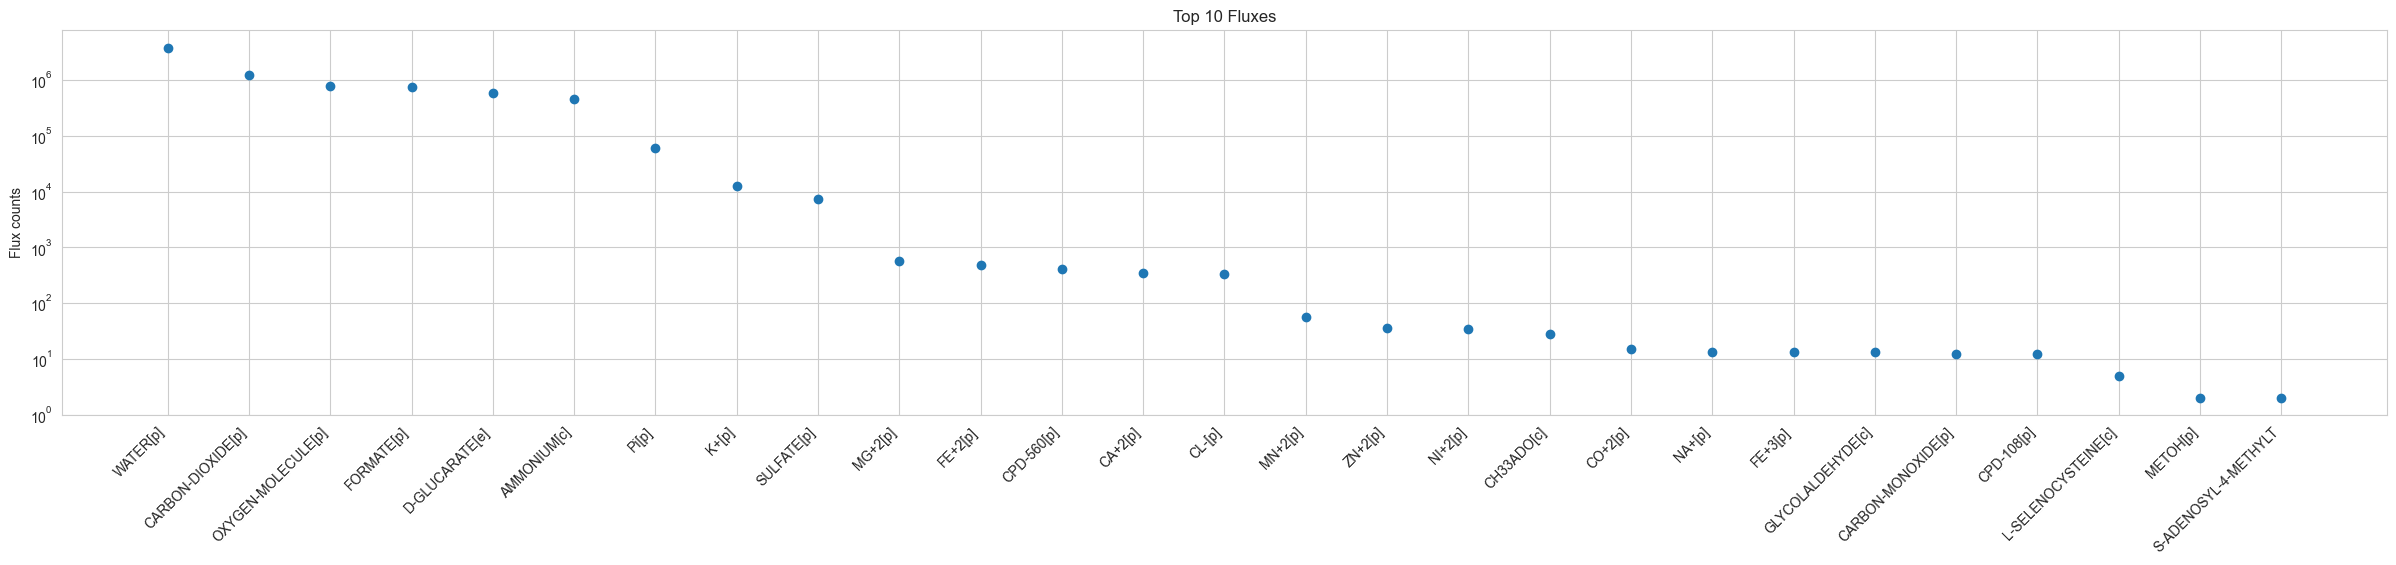

In [93]:
cur_exchanges = pd.Series(solution.exchanges, index=metabolism_cp1.metabolite_names).abs().sort_values(ascending=False)
nonzero = len(cur_exchanges[cur_exchanges > 0])

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(30, 5))
plt.plot(cur_exchanges.head(nonzero), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(nonzero)], [i[:20] for i in cur_exchanges.index[:nonzero]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 Fluxes')
plt.show()

In [94]:
conditions = {
    # 'Isoprimeverose': {
    #     'Add': {'CPD0-1202[e]'},
    #     'Remove': {'GLC[p]'},
    #     'Exchange': {'CPD0-1202[e]'}
    # },
    # 'Oxamate': {
    #     'Add': {'S-ALLANTOIN[e]'},
    #     'Remove': {'AMMONIUM[c]', 'OXYGEN-MOLECULE[p]'},
    #     'Exchange': {'S-ALLANTOIN[e]', 'OXAMATE[e]'}
    # },
    # 'Trehalose':{
    #     'Add': {'TREHALOSE[e]'},
    #     'Remove': {'GLC[p]'},
    #     'Exchange': set()
    # },
    # 'GLC-1-P':{
    #     'Add': {'GLC-1-P[e]'},
    #     'Remove': {'GLC[p]'},
    #     'Exchange': set()
    # },
    '3-HYDROXYPHENYL-PROPIONATE':{
        'Add': set(['3-HYDROXYPHENYL-PROPIONATE[e]']),
        'Remove': set(['GLC[p]'])
    },
    # '3-PHENYLPROPIONATE':{
    #     'Add': {'3-PHENYLPROPIONATE[e]'},
    #     'Remove': {'GLC[p]'}
    # },
    # 'cinnate':{
    #     'Add': {'CPD-10797[e]', 'CPD-674[e]'},
    #     'Remove': {'GLC[p]'}
    # },
    # 'L-galactonate':{
    #     'Add': {'CPD0-1083[e]'},
    #     'Remove': {'GLC[p]'}
    # },
    # 'D-GLUCARATE':{
    #     'Add': {'D-GLUCARATE[e]'},
    #     'Remove': {'GLC[p]'}
    # }
}

In [95]:
for condition_name, condition in conditions.items():
    solution_flux, test_reaction_names, S_new, test_metabolites, test_kinetic = test_NetworkFlowModel(
                                            objective_weights, 
                                            uptake_addition=condition['Add'], uptake_removal=condition['Remove'],
                                            # new_exchange_molecules=new_exchange_molecules,
                                            # force_reaction=force_reaction
    )
    sim_flux = pd.DataFrame({
    'flux': solution_flux,
    'is_new': [
        'New Reactions' if id in fba_new_reaction_ids_unmodified 
        else 'TEMP' if id in add_reaction.keys() 
        else 'Old Reactions' 
            for id in test_reaction_names
    ]
    }, index=test_reaction_names)
    met_of_interest = ['2-3-DIHYDROXYPHENYL-PROPIONATE[c]', 'CPD-10796[c]', 'CPD-157[c]','CPD0-2184[c]',
                   '3-HYDROXYPHENYL-PROPIONATE[c]','CARBOXYETHYL-3-5-CYCLOHEXADIENE-1-2-DIOL[c]']
    S_new = pd.DataFrame(S_new, index=test_metabolites, columns=test_reaction_names)
    S_met, rxns  = get_subset_S(S_new, met_of_interest)
    rxns
    rxn_flux = sim_flux.loc[rxns]
    rxn_flux['kinetic'] = [test_kinetic[r] if r in kinetic_reaction_ids else False for r in rxn_flux.index]
    print(rxn_flux)

Force Reaction ID is: None
Optimal objective function reached is: 21774.15514901578
                                flux         is_new kinetic
1.13.11.16-RXN           295747.0625  New Reactions    67.0
HCAMULTI-RXN                  0.0000  New Reactions   False
MHPCHYDROL-RXN           295747.0625  New Reactions   165.0
MHPHYDROXY-RXN           295747.0625  New Reactions   False
PHENPRODIOLDEHYDROG-RXN       0.0000  New Reactions   False
RXN-10040                    -0.0000  New Reactions   False
RXN-12070                    -0.0000  New Reactions     5.0
RXN-12071                    -0.0000  New Reactions   False
RXN-12073                    -0.0000  New Reactions   False
TRANS-RXN-61             295747.0625  New Reactions   False


In [96]:
objective_weights

{'secretion': 0.01, 'efficiency': 1e-06, 'kinetics': 1e-06}